In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 717.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.6 MB/s eta 0:00:00


In [4]:
import pandas as pd

filtered_df = pd.read_csv('drive/MyDrive/TFM/GeneRIF/interactions_human_reduced.csv')
df = filtered_df[['gene_id','interactant_id']].drop_duplicates().sort_values(by=['gene_id','interactant_id'])
graph_df = df.loc[df['gene_id'] != df['interactant_id']]

In [7]:
import torch
import torch.optim as optim
import networkx as nx
from torch_geometric.utils import from_networkx
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE
import random
from sklearn.model_selection import train_test_split

model_map = {
    'transe': TransE,
    'complex': ComplEx,
    'distmult': DistMult,
    'rotate': RotatE,
}

model_choice = 'distmult'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

G = nx.from_pandas_edgelist(df, 'gene_id', 'interactant_id', create_using=nx.Graph())

G = G.to_directed()

for u, v in list(G.edges()):
    G.add_edge(v, u, relation=0)

original_labels = list(G.nodes)
mapping = {label: idx for idx, label in enumerate(original_labels)}
G = nx.relabel_nodes(G, mapping)

data = from_networkx(G)

data.edge_type = torch.tensor([G[u][v]['relation'] for u, v in G.edges()])

edges = data.edge_index.T.tolist()
edge_type = data.edge_type.tolist()

train_edges, temp_edges, train_edge_type, temp_edge_type = train_test_split(edges, edge_type, test_size=0.2, random_state=42)

val_edges, test_edges, val_edge_type, test_edge_type = train_test_split(temp_edges, temp_edge_type, test_size=0.5, random_state=42)

train_data = data.clone()
train_data.edge_index = torch.tensor(train_edges).T.to(device)
train_data.edge_type = torch.tensor(train_edge_type).to(device)

val_data = data.clone()
val_data.edge_index = torch.tensor(val_edges).T.to(device)
val_data.edge_type = torch.tensor(val_edge_type).to(device)

test_data = data.clone()
test_data.edge_index = torch.tensor(test_edges).T.to(device)
test_data.edge_type = torch.tensor(test_edge_type).to(device)

model_arg_map = {'rotate': {'margin': 9.0}}
model = model_map[model_choice](
    num_nodes=train_data.num_nodes,
    num_relations=train_data.edge_type.max().item() + 1,
    hidden_channels=50,
    **model_arg_map.get(model_choice, {}),
).to(device)

loader = model.loader(
    head_index=train_data.edge_index[0],
    rel_type=train_data.edge_type,
    tail_index=train_data.edge_index[1],
    batch_size=1000,
    shuffle=True,
)

optimizer_map = {
    'transe': optim.Adam(model.parameters(), lr=0.01),
    'complex': optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-6),
    'distmult': optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6),
    'rotate': optim.Adam(model.parameters(), lr=1e-3),
}
optimizer = optimizer_map[model_choice]

def train():
    model.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples

@torch.no_grad()
def test(data):
    model.eval()
    return model.test(
        head_index=data.edge_index[0],
        rel_type=data.edge_type,
        tail_index=data.edge_index[1],
        batch_size=20000,
        k=10,
    )

for epoch in range(1, 501):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
              f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

rank, mrr, hits_at_10 = test(test_data)
print(f'Test Mean Rank: {rank:.2f}, Test MRR: {mrr:.4f}, '
      f'Test Hits@10: {hits_at_10:.4f}')


Epoch: 001, Loss: 0.9994
Epoch: 002, Loss: 0.9437
Epoch: 003, Loss: 0.7403
Epoch: 004, Loss: 0.6054
Epoch: 005, Loss: 0.5448
Epoch: 006, Loss: 0.5066
Epoch: 007, Loss: 0.4774
Epoch: 008, Loss: 0.4560
Epoch: 009, Loss: 0.4361
Epoch: 010, Loss: 0.4192
Epoch: 011, Loss: 0.4035
Epoch: 012, Loss: 0.3888
Epoch: 013, Loss: 0.3746
Epoch: 014, Loss: 0.3616
Epoch: 015, Loss: 0.3493
Epoch: 016, Loss: 0.3384
Epoch: 017, Loss: 0.3278
Epoch: 018, Loss: 0.3190
Epoch: 019, Loss: 0.3101
Epoch: 020, Loss: 0.3023
Epoch: 021, Loss: 0.2953
Epoch: 022, Loss: 0.2888
Epoch: 023, Loss: 0.2824
Epoch: 024, Loss: 0.2764
Epoch: 025, Loss: 0.2721


100%|██████████| 168129/168129 [01:10<00:00, 2395.47it/s]


Epoch: 025, Val Mean Rank: 2228.47, Val MRR: 0.0143, Val Hits@10: 0.0287
Epoch: 026, Loss: 0.2678
Epoch: 027, Loss: 0.2630
Epoch: 028, Loss: 0.2589
Epoch: 029, Loss: 0.2542
Epoch: 030, Loss: 0.2506
Epoch: 031, Loss: 0.2472
Epoch: 032, Loss: 0.2435
Epoch: 033, Loss: 0.2387
Epoch: 034, Loss: 0.2362
Epoch: 035, Loss: 0.2326
Epoch: 036, Loss: 0.2295
Epoch: 037, Loss: 0.2274
Epoch: 038, Loss: 0.2237
Epoch: 039, Loss: 0.2204
Epoch: 040, Loss: 0.2183
Epoch: 041, Loss: 0.2148
Epoch: 042, Loss: 0.2119
Epoch: 043, Loss: 0.2097
Epoch: 044, Loss: 0.2073
Epoch: 045, Loss: 0.2046
Epoch: 046, Loss: 0.2015
Epoch: 047, Loss: 0.1994
Epoch: 048, Loss: 0.1964
Epoch: 049, Loss: 0.1942
Epoch: 050, Loss: 0.1924


100%|██████████| 168129/168129 [01:10<00:00, 2382.89it/s]


Epoch: 050, Val Mean Rank: 1725.93, Val MRR: 0.0172, Val Hits@10: 0.0341
Epoch: 051, Loss: 0.1888
Epoch: 052, Loss: 0.1868
Epoch: 053, Loss: 0.1849
Epoch: 054, Loss: 0.1830
Epoch: 055, Loss: 0.1807
Epoch: 056, Loss: 0.1781
Epoch: 057, Loss: 0.1765
Epoch: 058, Loss: 0.1747
Epoch: 059, Loss: 0.1729
Epoch: 060, Loss: 0.1708
Epoch: 061, Loss: 0.1685
Epoch: 062, Loss: 0.1663
Epoch: 063, Loss: 0.1647
Epoch: 064, Loss: 0.1638
Epoch: 065, Loss: 0.1613
Epoch: 066, Loss: 0.1600
Epoch: 067, Loss: 0.1583
Epoch: 068, Loss: 0.1563
Epoch: 069, Loss: 0.1556
Epoch: 070, Loss: 0.1537
Epoch: 071, Loss: 0.1516
Epoch: 072, Loss: 0.1510
Epoch: 073, Loss: 0.1501
Epoch: 074, Loss: 0.1480
Epoch: 075, Loss: 0.1472


100%|██████████| 168129/168129 [01:10<00:00, 2391.53it/s]


Epoch: 075, Val Mean Rank: 1463.98, Val MRR: 0.0183, Val Hits@10: 0.0359
Epoch: 076, Loss: 0.1456
Epoch: 077, Loss: 0.1443
Epoch: 078, Loss: 0.1424
Epoch: 079, Loss: 0.1412
Epoch: 080, Loss: 0.1396
Epoch: 081, Loss: 0.1398
Epoch: 082, Loss: 0.1382
Epoch: 083, Loss: 0.1370
Epoch: 084, Loss: 0.1362
Epoch: 085, Loss: 0.1353
Epoch: 086, Loss: 0.1342
Epoch: 087, Loss: 0.1329
Epoch: 088, Loss: 0.1318
Epoch: 089, Loss: 0.1309
Epoch: 090, Loss: 0.1299
Epoch: 091, Loss: 0.1289
Epoch: 092, Loss: 0.1284
Epoch: 093, Loss: 0.1275
Epoch: 094, Loss: 0.1263
Epoch: 095, Loss: 0.1258
Epoch: 096, Loss: 0.1246
Epoch: 097, Loss: 0.1242
Epoch: 098, Loss: 0.1234
Epoch: 099, Loss: 0.1223
Epoch: 100, Loss: 0.1219


100%|██████████| 168129/168129 [01:10<00:00, 2391.42it/s]


Epoch: 100, Val Mean Rank: 1318.57, Val MRR: 0.0190, Val Hits@10: 0.0372
Epoch: 101, Loss: 0.1208
Epoch: 102, Loss: 0.1206
Epoch: 103, Loss: 0.1197
Epoch: 104, Loss: 0.1196
Epoch: 105, Loss: 0.1187
Epoch: 106, Loss: 0.1177
Epoch: 107, Loss: 0.1173
Epoch: 108, Loss: 0.1166
Epoch: 109, Loss: 0.1158
Epoch: 110, Loss: 0.1154
Epoch: 111, Loss: 0.1151
Epoch: 112, Loss: 0.1141
Epoch: 113, Loss: 0.1137
Epoch: 114, Loss: 0.1134
Epoch: 115, Loss: 0.1128
Epoch: 116, Loss: 0.1121
Epoch: 117, Loss: 0.1120
Epoch: 118, Loss: 0.1115
Epoch: 119, Loss: 0.1106
Epoch: 120, Loss: 0.1103
Epoch: 121, Loss: 0.1100
Epoch: 122, Loss: 0.1094
Epoch: 123, Loss: 0.1094
Epoch: 124, Loss: 0.1088
Epoch: 125, Loss: 0.1086


100%|██████████| 168129/168129 [01:10<00:00, 2380.74it/s]


Epoch: 125, Val Mean Rank: 1235.35, Val MRR: 0.0194, Val Hits@10: 0.0383
Epoch: 126, Loss: 0.1077
Epoch: 127, Loss: 0.1075
Epoch: 128, Loss: 0.1071
Epoch: 129, Loss: 0.1073
Epoch: 130, Loss: 0.1064
Epoch: 131, Loss: 0.1059
Epoch: 132, Loss: 0.1062
Epoch: 133, Loss: 0.1050
Epoch: 134, Loss: 0.1053
Epoch: 135, Loss: 0.1045
Epoch: 136, Loss: 0.1048
Epoch: 137, Loss: 0.1041
Epoch: 138, Loss: 0.1037
Epoch: 139, Loss: 0.1036
Epoch: 140, Loss: 0.1032
Epoch: 141, Loss: 0.1028
Epoch: 142, Loss: 0.1023
Epoch: 143, Loss: 0.1026
Epoch: 144, Loss: 0.1029
Epoch: 145, Loss: 0.1013
Epoch: 146, Loss: 0.1019
Epoch: 147, Loss: 0.1017
Epoch: 148, Loss: 0.1013
Epoch: 149, Loss: 0.1011
Epoch: 150, Loss: 0.1011


100%|██████████| 168129/168129 [01:11<00:00, 2367.19it/s]


Epoch: 150, Val Mean Rank: 1185.02, Val MRR: 0.0197, Val Hits@10: 0.0385
Epoch: 151, Loss: 0.1006
Epoch: 152, Loss: 0.1001
Epoch: 153, Loss: 0.1002
Epoch: 154, Loss: 0.0995
Epoch: 155, Loss: 0.0995
Epoch: 156, Loss: 0.0995
Epoch: 157, Loss: 0.0988
Epoch: 158, Loss: 0.0985
Epoch: 159, Loss: 0.0987
Epoch: 160, Loss: 0.0986
Epoch: 161, Loss: 0.0984
Epoch: 162, Loss: 0.0985
Epoch: 163, Loss: 0.0981
Epoch: 164, Loss: 0.0976
Epoch: 165, Loss: 0.0975
Epoch: 166, Loss: 0.0971
Epoch: 167, Loss: 0.0974
Epoch: 168, Loss: 0.0972
Epoch: 169, Loss: 0.0972
Epoch: 170, Loss: 0.0972
Epoch: 171, Loss: 0.0968
Epoch: 172, Loss: 0.0970
Epoch: 173, Loss: 0.0960
Epoch: 174, Loss: 0.0957
Epoch: 175, Loss: 0.0960


100%|██████████| 168129/168129 [01:10<00:00, 2381.42it/s]


Epoch: 175, Val Mean Rank: 1154.26, Val MRR: 0.0198, Val Hits@10: 0.0379
Epoch: 176, Loss: 0.0951
Epoch: 177, Loss: 0.0956
Epoch: 178, Loss: 0.0952
Epoch: 179, Loss: 0.0954
Epoch: 180, Loss: 0.0948
Epoch: 181, Loss: 0.0948
Epoch: 182, Loss: 0.0951
Epoch: 183, Loss: 0.0944
Epoch: 184, Loss: 0.0953
Epoch: 185, Loss: 0.0951
Epoch: 186, Loss: 0.0946
Epoch: 187, Loss: 0.0948
Epoch: 188, Loss: 0.0944
Epoch: 189, Loss: 0.0942
Epoch: 190, Loss: 0.0941
Epoch: 191, Loss: 0.0942
Epoch: 192, Loss: 0.0937
Epoch: 193, Loss: 0.0935
Epoch: 194, Loss: 0.0940
Epoch: 195, Loss: 0.0938
Epoch: 196, Loss: 0.0932
Epoch: 197, Loss: 0.0929
Epoch: 198, Loss: 0.0930
Epoch: 199, Loss: 0.0929
Epoch: 200, Loss: 0.0926


100%|██████████| 168129/168129 [01:10<00:00, 2375.88it/s]


Epoch: 200, Val Mean Rank: 1135.75, Val MRR: 0.0200, Val Hits@10: 0.0381
Epoch: 201, Loss: 0.0921
Epoch: 202, Loss: 0.0931
Epoch: 203, Loss: 0.0927
Epoch: 204, Loss: 0.0925
Epoch: 205, Loss: 0.0930
Epoch: 206, Loss: 0.0925
Epoch: 207, Loss: 0.0924
Epoch: 208, Loss: 0.0927
Epoch: 209, Loss: 0.0922
Epoch: 210, Loss: 0.0921
Epoch: 211, Loss: 0.0923
Epoch: 212, Loss: 0.0921
Epoch: 213, Loss: 0.0916
Epoch: 214, Loss: 0.0920
Epoch: 215, Loss: 0.0922
Epoch: 216, Loss: 0.0913
Epoch: 217, Loss: 0.0912
Epoch: 218, Loss: 0.0912
Epoch: 219, Loss: 0.0919
Epoch: 220, Loss: 0.0919
Epoch: 221, Loss: 0.0921
Epoch: 222, Loss: 0.0905
Epoch: 223, Loss: 0.0915
Epoch: 224, Loss: 0.0910
Epoch: 225, Loss: 0.0912


100%|██████████| 168129/168129 [01:10<00:00, 2378.35it/s]


Epoch: 225, Val Mean Rank: 1124.35, Val MRR: 0.0197, Val Hits@10: 0.0381
Epoch: 226, Loss: 0.0909
Epoch: 227, Loss: 0.0908
Epoch: 228, Loss: 0.0904
Epoch: 229, Loss: 0.0904
Epoch: 230, Loss: 0.0905
Epoch: 231, Loss: 0.0906
Epoch: 232, Loss: 0.0910
Epoch: 233, Loss: 0.0903
Epoch: 234, Loss: 0.0904
Epoch: 235, Loss: 0.0903
Epoch: 236, Loss: 0.0903
Epoch: 237, Loss: 0.0902
Epoch: 238, Loss: 0.0900
Epoch: 239, Loss: 0.0898
Epoch: 240, Loss: 0.0898
Epoch: 241, Loss: 0.0897
Epoch: 242, Loss: 0.0899
Epoch: 243, Loss: 0.0892
Epoch: 244, Loss: 0.0893
Epoch: 245, Loss: 0.0895
Epoch: 246, Loss: 0.0896
Epoch: 247, Loss: 0.0895
Epoch: 248, Loss: 0.0897
Epoch: 249, Loss: 0.0900
Epoch: 250, Loss: 0.0895


100%|██████████| 168129/168129 [01:10<00:00, 2381.83it/s]


Epoch: 250, Val Mean Rank: 1114.80, Val MRR: 0.0198, Val Hits@10: 0.0382
Epoch: 251, Loss: 0.0892
Epoch: 252, Loss: 0.0891
Epoch: 253, Loss: 0.0891
Epoch: 254, Loss: 0.0894
Epoch: 255, Loss: 0.0893
Epoch: 256, Loss: 0.0895
Epoch: 257, Loss: 0.0888
Epoch: 258, Loss: 0.0888
Epoch: 259, Loss: 0.0887
Epoch: 260, Loss: 0.0884
Epoch: 261, Loss: 0.0892
Epoch: 262, Loss: 0.0888
Epoch: 263, Loss: 0.0893
Epoch: 264, Loss: 0.0887
Epoch: 265, Loss: 0.0893
Epoch: 266, Loss: 0.0888
Epoch: 267, Loss: 0.0884
Epoch: 268, Loss: 0.0886
Epoch: 269, Loss: 0.0879
Epoch: 270, Loss: 0.0886
Epoch: 271, Loss: 0.0886
Epoch: 272, Loss: 0.0887
Epoch: 273, Loss: 0.0882
Epoch: 274, Loss: 0.0888
Epoch: 275, Loss: 0.0885


100%|██████████| 168129/168129 [01:10<00:00, 2381.32it/s]


Epoch: 275, Val Mean Rank: 1109.14, Val MRR: 0.0197, Val Hits@10: 0.0379
Epoch: 276, Loss: 0.0882
Epoch: 277, Loss: 0.0886
Epoch: 278, Loss: 0.0882
Epoch: 279, Loss: 0.0887
Epoch: 280, Loss: 0.0882
Epoch: 281, Loss: 0.0885
Epoch: 282, Loss: 0.0881
Epoch: 283, Loss: 0.0880
Epoch: 284, Loss: 0.0873
Epoch: 285, Loss: 0.0879
Epoch: 286, Loss: 0.0878
Epoch: 287, Loss: 0.0878
Epoch: 288, Loss: 0.0876
Epoch: 289, Loss: 0.0882
Epoch: 290, Loss: 0.0880
Epoch: 291, Loss: 0.0873
Epoch: 292, Loss: 0.0875
Epoch: 293, Loss: 0.0872
Epoch: 294, Loss: 0.0882
Epoch: 295, Loss: 0.0882
Epoch: 296, Loss: 0.0873
Epoch: 297, Loss: 0.0883
Epoch: 298, Loss: 0.0876
Epoch: 299, Loss: 0.0874
Epoch: 300, Loss: 0.0873


100%|██████████| 168129/168129 [01:10<00:00, 2381.97it/s]


Epoch: 300, Val Mean Rank: 1104.40, Val MRR: 0.0197, Val Hits@10: 0.0377
Epoch: 301, Loss: 0.0874
Epoch: 302, Loss: 0.0874
Epoch: 303, Loss: 0.0871
Epoch: 304, Loss: 0.0868
Epoch: 305, Loss: 0.0873
Epoch: 306, Loss: 0.0870
Epoch: 307, Loss: 0.0869
Epoch: 308, Loss: 0.0873
Epoch: 309, Loss: 0.0869
Epoch: 310, Loss: 0.0873
Epoch: 311, Loss: 0.0871
Epoch: 312, Loss: 0.0879
Epoch: 313, Loss: 0.0873
Epoch: 314, Loss: 0.0872
Epoch: 315, Loss: 0.0871
Epoch: 316, Loss: 0.0867
Epoch: 317, Loss: 0.0871
Epoch: 318, Loss: 0.0871
Epoch: 319, Loss: 0.0870
Epoch: 320, Loss: 0.0867
Epoch: 321, Loss: 0.0867
Epoch: 322, Loss: 0.0868
Epoch: 323, Loss: 0.0873
Epoch: 324, Loss: 0.0871
Epoch: 325, Loss: 0.0866


100%|██████████| 168129/168129 [01:10<00:00, 2375.67it/s]


Epoch: 325, Val Mean Rank: 1099.51, Val MRR: 0.0196, Val Hits@10: 0.0376
Epoch: 326, Loss: 0.0872
Epoch: 327, Loss: 0.0872
Epoch: 328, Loss: 0.0871
Epoch: 329, Loss: 0.0866
Epoch: 330, Loss: 0.0865
Epoch: 331, Loss: 0.0867
Epoch: 332, Loss: 0.0866
Epoch: 333, Loss: 0.0864
Epoch: 334, Loss: 0.0864
Epoch: 335, Loss: 0.0863
Epoch: 336, Loss: 0.0866
Epoch: 337, Loss: 0.0862
Epoch: 338, Loss: 0.0868
Epoch: 339, Loss: 0.0857
Epoch: 340, Loss: 0.0864
Epoch: 341, Loss: 0.0865
Epoch: 342, Loss: 0.0864
Epoch: 343, Loss: 0.0865
Epoch: 344, Loss: 0.0862
Epoch: 345, Loss: 0.0866
Epoch: 346, Loss: 0.0862
Epoch: 347, Loss: 0.0866
Epoch: 348, Loss: 0.0863
Epoch: 349, Loss: 0.0862
Epoch: 350, Loss: 0.0864


100%|██████████| 168129/168129 [01:10<00:00, 2385.11it/s]


Epoch: 350, Val Mean Rank: 1097.16, Val MRR: 0.0197, Val Hits@10: 0.0379
Epoch: 351, Loss: 0.0861
Epoch: 352, Loss: 0.0861
Epoch: 353, Loss: 0.0860
Epoch: 354, Loss: 0.0859
Epoch: 355, Loss: 0.0859
Epoch: 356, Loss: 0.0863
Epoch: 357, Loss: 0.0855
Epoch: 358, Loss: 0.0856
Epoch: 359, Loss: 0.0860
Epoch: 360, Loss: 0.0863
Epoch: 361, Loss: 0.0859
Epoch: 362, Loss: 0.0860
Epoch: 363, Loss: 0.0856
Epoch: 364, Loss: 0.0858
Epoch: 365, Loss: 0.0858
Epoch: 366, Loss: 0.0861
Epoch: 367, Loss: 0.0863
Epoch: 368, Loss: 0.0857
Epoch: 369, Loss: 0.0860
Epoch: 370, Loss: 0.0860
Epoch: 371, Loss: 0.0860
Epoch: 372, Loss: 0.0852
Epoch: 373, Loss: 0.0856
Epoch: 374, Loss: 0.0855
Epoch: 375, Loss: 0.0855


100%|██████████| 168129/168129 [01:10<00:00, 2374.53it/s]


Epoch: 375, Val Mean Rank: 1094.46, Val MRR: 0.0198, Val Hits@10: 0.0376
Epoch: 376, Loss: 0.0859
Epoch: 377, Loss: 0.0855
Epoch: 378, Loss: 0.0851
Epoch: 379, Loss: 0.0852
Epoch: 380, Loss: 0.0856
Epoch: 381, Loss: 0.0853
Epoch: 382, Loss: 0.0857
Epoch: 383, Loss: 0.0854
Epoch: 384, Loss: 0.0856
Epoch: 385, Loss: 0.0854
Epoch: 386, Loss: 0.0852
Epoch: 387, Loss: 0.0859
Epoch: 388, Loss: 0.0854
Epoch: 389, Loss: 0.0853
Epoch: 390, Loss: 0.0855
Epoch: 391, Loss: 0.0853
Epoch: 392, Loss: 0.0856
Epoch: 393, Loss: 0.0853
Epoch: 394, Loss: 0.0854
Epoch: 395, Loss: 0.0851
Epoch: 396, Loss: 0.0852
Epoch: 397, Loss: 0.0853
Epoch: 398, Loss: 0.0850
Epoch: 399, Loss: 0.0853
Epoch: 400, Loss: 0.0849


100%|██████████| 168129/168129 [01:10<00:00, 2376.18it/s]


Epoch: 400, Val Mean Rank: 1090.75, Val MRR: 0.0198, Val Hits@10: 0.0376
Epoch: 401, Loss: 0.0852
Epoch: 402, Loss: 0.0846
Epoch: 403, Loss: 0.0851
Epoch: 404, Loss: 0.0858
Epoch: 405, Loss: 0.0852
Epoch: 406, Loss: 0.0852
Epoch: 407, Loss: 0.0853
Epoch: 408, Loss: 0.0852
Epoch: 409, Loss: 0.0855
Epoch: 410, Loss: 0.0845
Epoch: 411, Loss: 0.0853
Epoch: 412, Loss: 0.0846
Epoch: 413, Loss: 0.0853
Epoch: 414, Loss: 0.0852
Epoch: 415, Loss: 0.0853
Epoch: 416, Loss: 0.0850
Epoch: 417, Loss: 0.0854
Epoch: 418, Loss: 0.0853
Epoch: 419, Loss: 0.0849
Epoch: 420, Loss: 0.0849
Epoch: 421, Loss: 0.0851
Epoch: 422, Loss: 0.0850
Epoch: 423, Loss: 0.0847
Epoch: 424, Loss: 0.0855
Epoch: 425, Loss: 0.0849


100%|██████████| 168129/168129 [01:10<00:00, 2382.27it/s]


Epoch: 425, Val Mean Rank: 1089.42, Val MRR: 0.0196, Val Hits@10: 0.0377
Epoch: 426, Loss: 0.0849
Epoch: 427, Loss: 0.0852
Epoch: 428, Loss: 0.0846
Epoch: 429, Loss: 0.0843
Epoch: 430, Loss: 0.0851
Epoch: 431, Loss: 0.0846
Epoch: 432, Loss: 0.0842
Epoch: 433, Loss: 0.0847
Epoch: 434, Loss: 0.0846
Epoch: 435, Loss: 0.0845
Epoch: 436, Loss: 0.0851
Epoch: 437, Loss: 0.0849
Epoch: 438, Loss: 0.0844
Epoch: 439, Loss: 0.0852
Epoch: 440, Loss: 0.0844
Epoch: 441, Loss: 0.0851
Epoch: 442, Loss: 0.0847
Epoch: 443, Loss: 0.0845
Epoch: 444, Loss: 0.0849
Epoch: 445, Loss: 0.0845
Epoch: 446, Loss: 0.0847
Epoch: 447, Loss: 0.0841
Epoch: 448, Loss: 0.0844
Epoch: 449, Loss: 0.0847
Epoch: 450, Loss: 0.0842


100%|██████████| 168129/168129 [01:10<00:00, 2370.24it/s]


Epoch: 450, Val Mean Rank: 1088.02, Val MRR: 0.0196, Val Hits@10: 0.0378
Epoch: 451, Loss: 0.0843
Epoch: 452, Loss: 0.0844
Epoch: 453, Loss: 0.0845
Epoch: 454, Loss: 0.0850
Epoch: 455, Loss: 0.0846
Epoch: 456, Loss: 0.0843
Epoch: 457, Loss: 0.0839
Epoch: 458, Loss: 0.0840
Epoch: 459, Loss: 0.0846
Epoch: 460, Loss: 0.0849
Epoch: 461, Loss: 0.0843
Epoch: 462, Loss: 0.0840
Epoch: 463, Loss: 0.0840
Epoch: 464, Loss: 0.0840
Epoch: 465, Loss: 0.0842
Epoch: 466, Loss: 0.0843
Epoch: 467, Loss: 0.0840
Epoch: 468, Loss: 0.0843
Epoch: 469, Loss: 0.0844
Epoch: 470, Loss: 0.0843
Epoch: 471, Loss: 0.0841
Epoch: 472, Loss: 0.0844
Epoch: 473, Loss: 0.0844
Epoch: 474, Loss: 0.0842
Epoch: 475, Loss: 0.0843


100%|██████████| 168129/168129 [01:10<00:00, 2386.83it/s]


Epoch: 475, Val Mean Rank: 1087.90, Val MRR: 0.0196, Val Hits@10: 0.0379
Epoch: 476, Loss: 0.0843
Epoch: 477, Loss: 0.0847
Epoch: 478, Loss: 0.0845
Epoch: 479, Loss: 0.0848
Epoch: 480, Loss: 0.0838
Epoch: 481, Loss: 0.0846
Epoch: 482, Loss: 0.0838
Epoch: 483, Loss: 0.0838
Epoch: 484, Loss: 0.0840
Epoch: 485, Loss: 0.0840
Epoch: 486, Loss: 0.0841
Epoch: 487, Loss: 0.0838
Epoch: 488, Loss: 0.0843
Epoch: 489, Loss: 0.0842
Epoch: 490, Loss: 0.0842
Epoch: 491, Loss: 0.0839
Epoch: 492, Loss: 0.0843
Epoch: 493, Loss: 0.0843
Epoch: 494, Loss: 0.0840
Epoch: 495, Loss: 0.0843
Epoch: 496, Loss: 0.0843
Epoch: 497, Loss: 0.0842
Epoch: 498, Loss: 0.0841
Epoch: 499, Loss: 0.0838
Epoch: 500, Loss: 0.0844


100%|██████████| 168129/168129 [01:10<00:00, 2388.48it/s]


Epoch: 500, Val Mean Rank: 1085.82, Val MRR: 0.0197, Val Hits@10: 0.0381


100%|██████████| 168129/168129 [01:10<00:00, 2384.94it/s]

Test Mean Rank: 1098.30, Test MRR: 0.0195, Test Hits@10: 0.0378


In [ ]:
model_save_path = 'distmult_model.pth'
torch.save(model.state_dict(), model_save_path)

In [8]:
import torch
import torch.optim as optim
import networkx as nx
from torch_geometric.utils import from_networkx
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE
import random
from sklearn.model_selection import train_test_split

model_map = {
    'transe': TransE,
    'complex': ComplEx,
    'distmult': DistMult,
    'rotate': RotatE,
}

model_choice = 'complex'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

G = nx.from_pandas_edgelist(df, 'gene_id', 'interactant_id', create_using=nx.Graph())

G = G.to_directed()

for u, v in list(G.edges()):
    G.add_edge(v, u, relation=0)

original_labels = list(G.nodes)
mapping = {label: idx for idx, label in enumerate(original_labels)}
G = nx.relabel_nodes(G, mapping)

data = from_networkx(G)

data.edge_type = torch.tensor([G[u][v]['relation'] for u, v in G.edges()])

edges = data.edge_index.T.tolist()
edge_type = data.edge_type.tolist()

train_edges, temp_edges, train_edge_type, temp_edge_type = train_test_split(edges, edge_type, test_size=0.2, random_state=42)

val_edges, test_edges, val_edge_type, test_edge_type = train_test_split(temp_edges, temp_edge_type, test_size=0.5, random_state=42)

train_data = data.clone()
train_data.edge_index = torch.tensor(train_edges).T.to(device)
train_data.edge_type = torch.tensor(train_edge_type).to(device)

val_data = data.clone()
val_data.edge_index = torch.tensor(val_edges).T.to(device)
val_data.edge_type = torch.tensor(val_edge_type).to(device)

test_data = data.clone()
test_data.edge_index = torch.tensor(test_edges).T.to(device)
test_data.edge_type = torch.tensor(test_edge_type).to(device)

model_arg_map = {'rotate': {'margin': 9.0}}
model = model_map[model_choice](
    num_nodes=train_data.num_nodes,
    num_relations=train_data.edge_type.max().item() + 1,
    hidden_channels=50,
    **model_arg_map.get(model_choice, {}),
).to(device)

loader = model.loader(
    head_index=train_data.edge_index[0],
    rel_type=train_data.edge_type,
    tail_index=train_data.edge_index[1],
    batch_size=1000,
    shuffle=True,
)

optimizer_map = {
    'transe': optim.Adam(model.parameters(), lr=0.01),
    'complex': optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-6),
    'distmult': optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6),
    'rotate': optim.Adam(model.parameters(), lr=1e-3),
}
optimizer = optimizer_map[model_choice]

def train():
    model.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples

@torch.no_grad()
def test(data):
    model.eval()
    return model.test(
        head_index=data.edge_index[0],
        rel_type=data.edge_type,
        tail_index=data.edge_index[1],
        batch_size=20000,
        k=10,
    )

for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
              f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

rank, mrr, hits_at_10 = test(test_data)
print(f'Test Mean Rank: {rank:.2f}, Test MRR: {mrr:.4f}, '
      f'Test Hits@10: {hits_at_10:.4f}')


Epoch: 001, Loss: 0.6931
Epoch: 002, Loss: 0.6931
Epoch: 003, Loss: 0.6926
Epoch: 004, Loss: 0.6913
Epoch: 005, Loss: 0.6891
Epoch: 006, Loss: 0.6860
Epoch: 007, Loss: 0.6820
Epoch: 008, Loss: 0.6774
Epoch: 009, Loss: 0.6725
Epoch: 010, Loss: 0.6674
Epoch: 011, Loss: 0.6623
Epoch: 012, Loss: 0.6572
Epoch: 013, Loss: 0.6524
Epoch: 014, Loss: 0.6476
Epoch: 015, Loss: 0.6431
Epoch: 016, Loss: 0.6389
Epoch: 017, Loss: 0.6349
Epoch: 018, Loss: 0.6312
Epoch: 019, Loss: 0.6278
Epoch: 020, Loss: 0.6246
Epoch: 021, Loss: 0.6217
Epoch: 022, Loss: 0.6189
Epoch: 023, Loss: 0.6163
Epoch: 024, Loss: 0.6141
Epoch: 025, Loss: 0.6119


100%|██████████| 168129/168129 [01:44<00:00, 1609.68it/s]


Epoch: 025, Val Mean Rank: 4396.72, Val MRR: 0.0092, Val Hits@10: 0.0192
Epoch: 026, Loss: 0.6097
Epoch: 027, Loss: 0.6078
Epoch: 028, Loss: 0.6062
Epoch: 029, Loss: 0.6044
Epoch: 030, Loss: 0.6031
Epoch: 031, Loss: 0.6013
Epoch: 032, Loss: 0.6003
Epoch: 033, Loss: 0.5990
Epoch: 034, Loss: 0.5977
Epoch: 035, Loss: 0.5967
Epoch: 036, Loss: 0.5955
Epoch: 037, Loss: 0.5946
Epoch: 038, Loss: 0.5936
Epoch: 039, Loss: 0.5929
Epoch: 040, Loss: 0.5917
Epoch: 041, Loss: 0.5910
Epoch: 042, Loss: 0.5900
Epoch: 043, Loss: 0.5897
Epoch: 044, Loss: 0.5888
Epoch: 045, Loss: 0.5883
Epoch: 046, Loss: 0.5871
Epoch: 047, Loss: 0.5870
Epoch: 048, Loss: 0.5862
Epoch: 049, Loss: 0.5854
Epoch: 050, Loss: 0.5848


100%|██████████| 168129/168129 [01:45<00:00, 1599.62it/s]


Epoch: 050, Val Mean Rank: 4240.48, Val MRR: 0.0094, Val Hits@10: 0.0191
Epoch: 051, Loss: 0.5843
Epoch: 052, Loss: 0.5837
Epoch: 053, Loss: 0.5832
Epoch: 054, Loss: 0.5826
Epoch: 055, Loss: 0.5822
Epoch: 056, Loss: 0.5812
Epoch: 057, Loss: 0.5812
Epoch: 058, Loss: 0.5808
Epoch: 059, Loss: 0.5801
Epoch: 060, Loss: 0.5796
Epoch: 061, Loss: 0.5795
Epoch: 062, Loss: 0.5792
Epoch: 063, Loss: 0.5786
Epoch: 064, Loss: 0.5780
Epoch: 065, Loss: 0.5777
Epoch: 066, Loss: 0.5772
Epoch: 067, Loss: 0.5768
Epoch: 068, Loss: 0.5768
Epoch: 069, Loss: 0.5757
Epoch: 070, Loss: 0.5756
Epoch: 071, Loss: 0.5753
Epoch: 072, Loss: 0.5748
Epoch: 073, Loss: 0.5744
Epoch: 074, Loss: 0.5741
Epoch: 075, Loss: 0.5735


100%|██████████| 168129/168129 [01:45<00:00, 1600.16it/s]


Epoch: 075, Val Mean Rank: 4083.50, Val MRR: 0.0098, Val Hits@10: 0.0195
Epoch: 076, Loss: 0.5733
Epoch: 077, Loss: 0.5736
Epoch: 078, Loss: 0.5726
Epoch: 079, Loss: 0.5725
Epoch: 080, Loss: 0.5719
Epoch: 081, Loss: 0.5714
Epoch: 082, Loss: 0.5714
Epoch: 083, Loss: 0.5708
Epoch: 084, Loss: 0.5706
Epoch: 085, Loss: 0.5705
Epoch: 086, Loss: 0.5702
Epoch: 087, Loss: 0.5695
Epoch: 088, Loss: 0.5691
Epoch: 089, Loss: 0.5691
Epoch: 090, Loss: 0.5688
Epoch: 091, Loss: 0.5686
Epoch: 092, Loss: 0.5678
Epoch: 093, Loss: 0.5678
Epoch: 094, Loss: 0.5674
Epoch: 095, Loss: 0.5673
Epoch: 096, Loss: 0.5672
Epoch: 097, Loss: 0.5667
Epoch: 098, Loss: 0.5662
Epoch: 099, Loss: 0.5659
Epoch: 100, Loss: 0.5655


100%|██████████| 168129/168129 [01:44<00:00, 1603.09it/s]


Epoch: 100, Val Mean Rank: 3934.75, Val MRR: 0.0102, Val Hits@10: 0.0201


100%|██████████| 168129/168129 [01:44<00:00, 1603.43it/s]


Test Mean Rank: 3930.22, Test MRR: 0.0100, Test Hits@10: 0.0198


In [9]:
model_save_path = 'complex_model.pth'
torch.save(model.state_dict(), model_save_path)

In [15]:
model_load_path = 'distmult_model.pth'
loaded_model = model_map['distmult'](
    num_nodes=data.num_nodes,
    num_relations=data.edge_type.max().item() + 1,
    hidden_channels=50,
    **model_arg_map.get('distmult', {}),
).to(device)

loaded_model.load_state_dict(torch.load(model_load_path))
loaded_model.eval()

max_score = float('-inf')
min_score = float('inf')

lst = list(G.edges())

for (head, tail) in lst:
    head_tensor = torch.tensor([head]).to(device)
    relation_tensor = torch.tensor([0]).to(device)
    tail_tensor = torch.tensor([tail]).to(device)
    score = loaded_model(head_tensor, relation_tensor, tail_tensor).item()

    max_score = max(max_score, score)
    min_score = min(min_score, score)

print(f"Maximum score: {max_score}")
print(f"Minimum score: {min_score}")


Maximum score: 11.970758438110352
Minimum score: -17.050769805908203


In [21]:
import random
import torch
import numpy as np

min_score_value = -17.05
max_score_value = 11.97

bin_edges = np.linspace(min_score_value, max_score_value, 21)
bin_centers = np.round((bin_edges[:-1] + bin_edges[1:]) / 2, 4)

histogram_data = {
    'actual_edges': {center: 0 for center in bin_centers},
    'random_edges': {center: 0 for center in bin_centers},
}

def find_bin(score, bin_edges):
    for i in range(len(bin_edges) - 1):
        if bin_edges[i] <= score < bin_edges[i + 1]:
            return bin_centers[i]
    return bin_centers[-1]

model_load_path = 'distmult_model.pth'
loaded_model = model_map['distmult'](
    num_nodes=data.num_nodes,
    num_relations=data.edge_type.max().item() + 1,
    hidden_channels=50,
    **model_arg_map.get('distmult', {}),
).to(device)

loaded_model.load_state_dict(torch.load(model_load_path))
loaded_model.eval()

edges_sample = random.sample(list(G.edges()), 100)

for (head, tail) in edges_sample:
    head_tensor = torch.tensor([head]).to(device)
    relation_tensor = torch.tensor([0]).to(device)
    tail_tensor = torch.tensor([tail]).to(device)
    score = loaded_model(head_tensor, relation_tensor, tail_tensor).item()

    bin_center = find_bin(score, bin_edges)
    histogram_data['actual_edges'][bin_center] += 1

non_edges_sample = set()

while len(non_edges_sample) < 100:
    head = random.randint(0, data.num_nodes - 1)
    tail = random.randint(0, data.num_nodes - 1)
    if (head, tail) not in G.edges() and (tail, head) not in G.edges():
        non_edges_sample.add((head, tail))
        head_tensor = torch.tensor([head]).to(device)
        relation_tensor = torch.tensor([0]).to(device)
        tail_tensor = torch.tensor([tail]).to(device)
        score = loaded_model(head_tensor, relation_tensor, tail_tensor).item()

        bin_center = find_bin(score, bin_edges)
        histogram_data['random_edges'][bin_center] += 1

print("Histogram data for actual edges:")
for bin_center, count in histogram_data['actual_edges'].items():
    print(f"Bin center {bin_center}: {count} occurrences")

print("\nHistogram data for random edges:")
for bin_center, count in histogram_data['random_edges'].items():
    print(f"Bin center {bin_center}: {count} occurrences")


Histogram data for actual edges:
Bin center -16.3245: 0 occurrences
Bin center -14.8735: 0 occurrences
Bin center -13.4225: 0 occurrences
Bin center -11.9715: 0 occurrences
Bin center -10.5205: 0 occurrences
Bin center -9.0695: 0 occurrences
Bin center -7.6185: 0 occurrences
Bin center -6.1675: 0 occurrences
Bin center -4.7165: 0 occurrences
Bin center -3.2655: 0 occurrences
Bin center -1.8145: 0 occurrences
Bin center -0.3635: 0 occurrences
Bin center 1.0875: 4 occurrences
Bin center 2.5385: 32 occurrences
Bin center 3.9895: 46 occurrences
Bin center 5.4405: 17 occurrences
Bin center 6.8915: 1 occurrences
Bin center 8.3425: 0 occurrences
Bin center 9.7935: 0 occurrences
Bin center 11.2445: 0 occurrences

Histogram data for random edges:
Bin center -16.3245: 0 occurrences
Bin center -14.8735: 0 occurrences
Bin center -13.4225: 0 occurrences
Bin center -11.9715: 0 occurrences
Bin center -10.5205: 0 occurrences
Bin center -9.0695: 0 occurrences
Bin center -7.6185: 0 occurrences
Bin cente

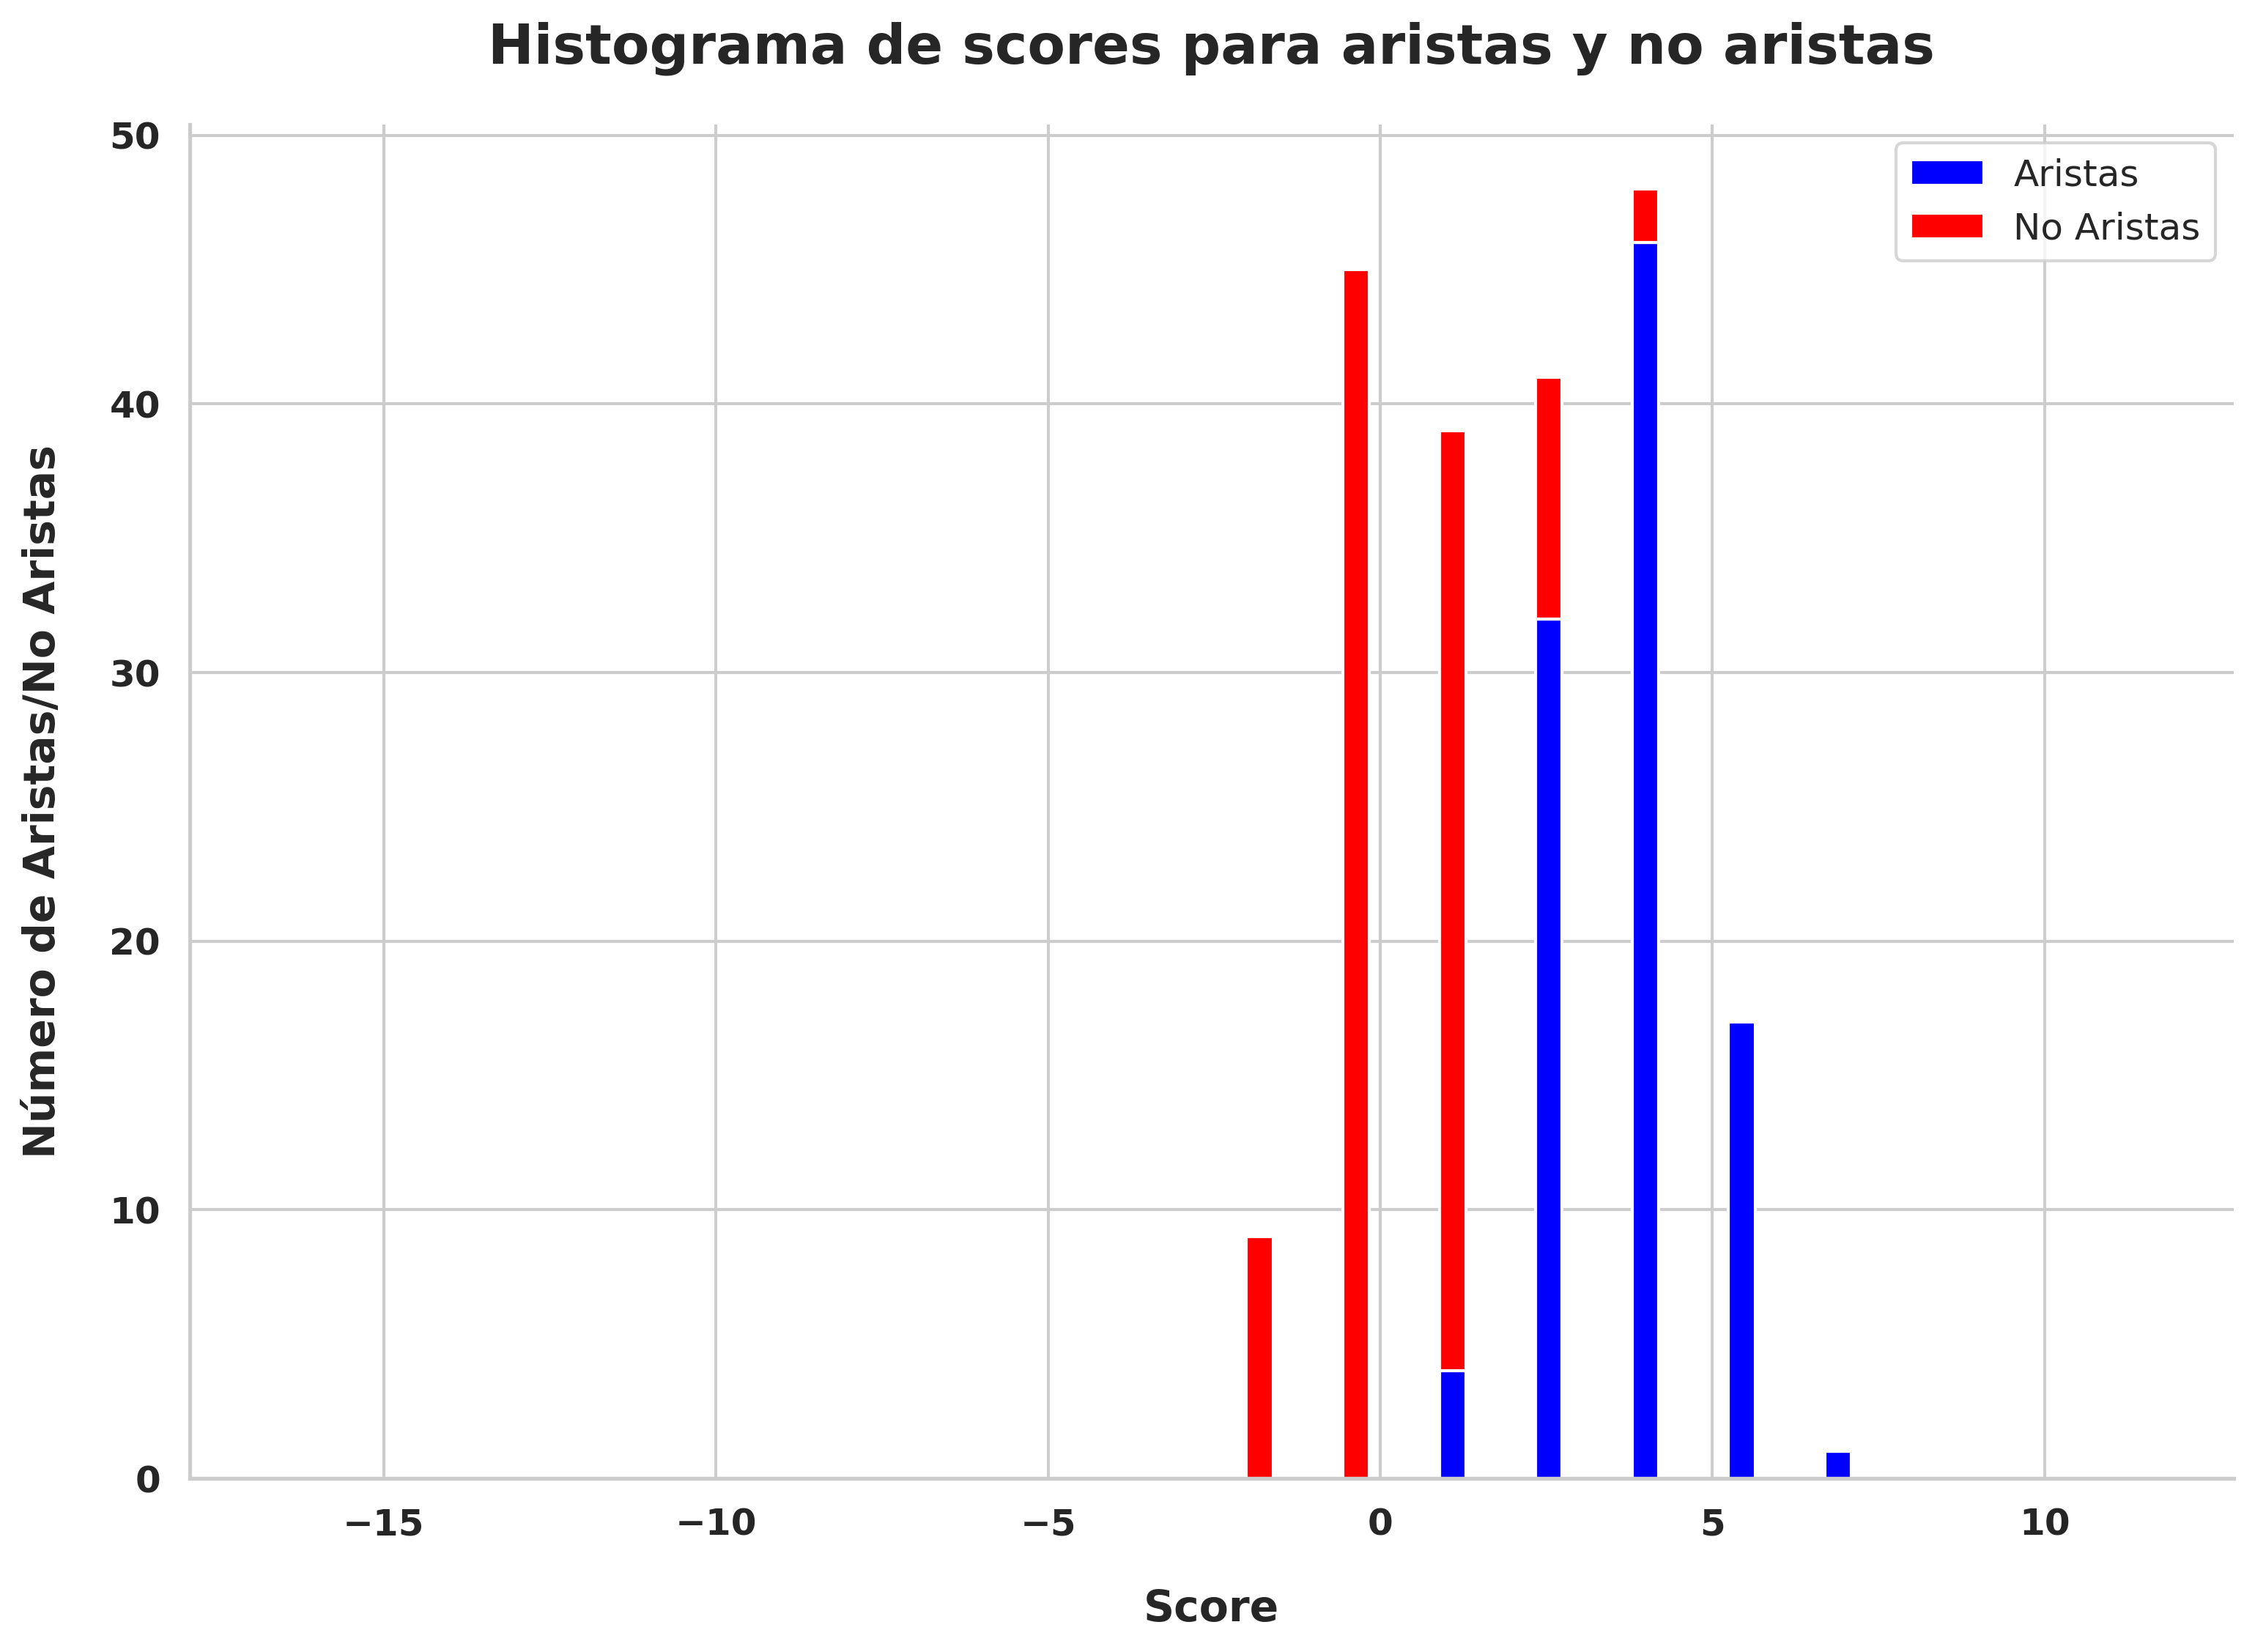

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Configuración del estilo de la gráfica
sns.set(style="whitegrid")

# Preparamos los datos para la gráfica
bin_centers = list(histogram_data['actual_edges'].keys())
edges_count = list(histogram_data['actual_edges'].values())
non_edges_count = list(histogram_data['random_edges'].values())

# Creamos la figura y la gráfica de barras apiladas
plt.figure(figsize=(12, 8), dpi=300)  # Configuración de alta resolución con dpi=300

# Barras para las aristas reales (azul) y no aristas (rojo)
plt.bar(bin_centers, edges_count, width=0.4, color='blue', label='Aristas')
plt.bar(bin_centers, non_edges_count, width=0.4, color='red', bottom=edges_count, label='No Aristas')

# Añadir títulos y etiquetas (fuente grande y negrita)
plt.title('Histograma de scores para aristas y no aristas', fontsize=18, weight='bold', pad=20)
plt.xlabel('Score', fontsize=14, weight='bold', labelpad=15)
plt.ylabel('Número de Aristas/No Aristas', fontsize=14, weight='bold', labelpad=15)

# Ajustamos el tamaño de las etiquetas
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

# Añadimos la leyenda y ajustar su posición
plt.legend(fontsize=12, loc='upper right')

# Formateamos el eje Y para mejor visualización
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Eliminamos bordes superiores y derechos para un diseño más limpio
sns.despine()

# Guardamos la figura en alta resolución
plt.savefig('distmult_histogram.png', dpi=300, bbox_inches='tight')

# Mostramos la gráfica
plt.show()


In [63]:
import numpy as np
import random
import torch

min_score_value = -5
max_score_value = 10

bin_edges = np.linspace(min_score_value, max_score_value, 36)
bin_centers = np.round((bin_edges[:-1] + bin_edges[1:]) / 2, 4)

histogram_data = {
    'actual_edges': {center: 0 for center in bin_centers},
    'random_edges': {center: 0 for center in bin_centers},
}

def find_bin(score, bin_edges):
    for i in range(len(bin_edges) - 1):
        if bin_edges[i] <= score < bin_edges[i + 1]:
            return bin_centers[i]
    return bin_centers[-1]

model_load_path = 'distmult_model.pth'
loaded_model = model_map['distmult'](
    num_nodes=data.num_nodes,
    num_relations=data.edge_type.max().item() + 1,
    hidden_channels=50,
    **model_arg_map.get('distmult', {}),
).to(device)

loaded_model.load_state_dict(torch.load(model_load_path))
loaded_model.eval()

edges_sample = random.sample(list(G.edges()), 250000)

c = 0
for (head, tail) in edges_sample:
    head_tensor = torch.tensor([head]).to(device)
    relation_tensor = torch.tensor([0]).to(device)
    tail_tensor = torch.tensor([tail]).to(device)
    score = loaded_model(head_tensor, relation_tensor, tail_tensor).item()

    bin_center = find_bin(score, bin_edges)
    histogram_data['actual_edges'][bin_center] += 1

    c += 1
    if c%1000 == 0: print('actual_edges', c)

non_edges_sample = set()

c = 0
while len(non_edges_sample) < 250000:
    head = random.randint(0, data.num_nodes - 1)
    tail = random.randint(0, data.num_nodes - 1)
    if (head, tail) not in G.edges() and (tail, head) not in G.edges():
        non_edges_sample.add((head, tail))
        head_tensor = torch.tensor([head]).to(device)
        relation_tensor = torch.tensor([0]).to(device)
        tail_tensor = torch.tensor([tail]).to(device)
        score = loaded_model(head_tensor, relation_tensor, tail_tensor).item()

        bin_center = find_bin(score, bin_edges)
        histogram_data['random_edges'][bin_center] += 1

        c += 1
        if c%1000 == 0: print('random_edges', c)


actual_edges 1000
actual_edges 2000
actual_edges 3000
actual_edges 4000
actual_edges 5000
actual_edges 6000
actual_edges 7000
actual_edges 8000
actual_edges 9000
actual_edges 10000
actual_edges 11000
actual_edges 12000
actual_edges 13000
actual_edges 14000
actual_edges 15000
actual_edges 16000
actual_edges 17000
actual_edges 18000
actual_edges 19000
actual_edges 20000
actual_edges 21000
actual_edges 22000
actual_edges 23000
actual_edges 24000
actual_edges 25000
actual_edges 26000
actual_edges 27000
actual_edges 28000
actual_edges 29000
actual_edges 30000
actual_edges 31000
actual_edges 32000
actual_edges 33000
actual_edges 34000
actual_edges 35000
actual_edges 36000
actual_edges 37000
actual_edges 38000
actual_edges 39000
actual_edges 40000
actual_edges 41000
actual_edges 42000
actual_edges 43000
actual_edges 44000
actual_edges 45000
actual_edges 46000
actual_edges 47000
actual_edges 48000
actual_edges 49000
actual_edges 50000
actual_edges 51000
actual_edges 52000
actual_edges 53000
ac

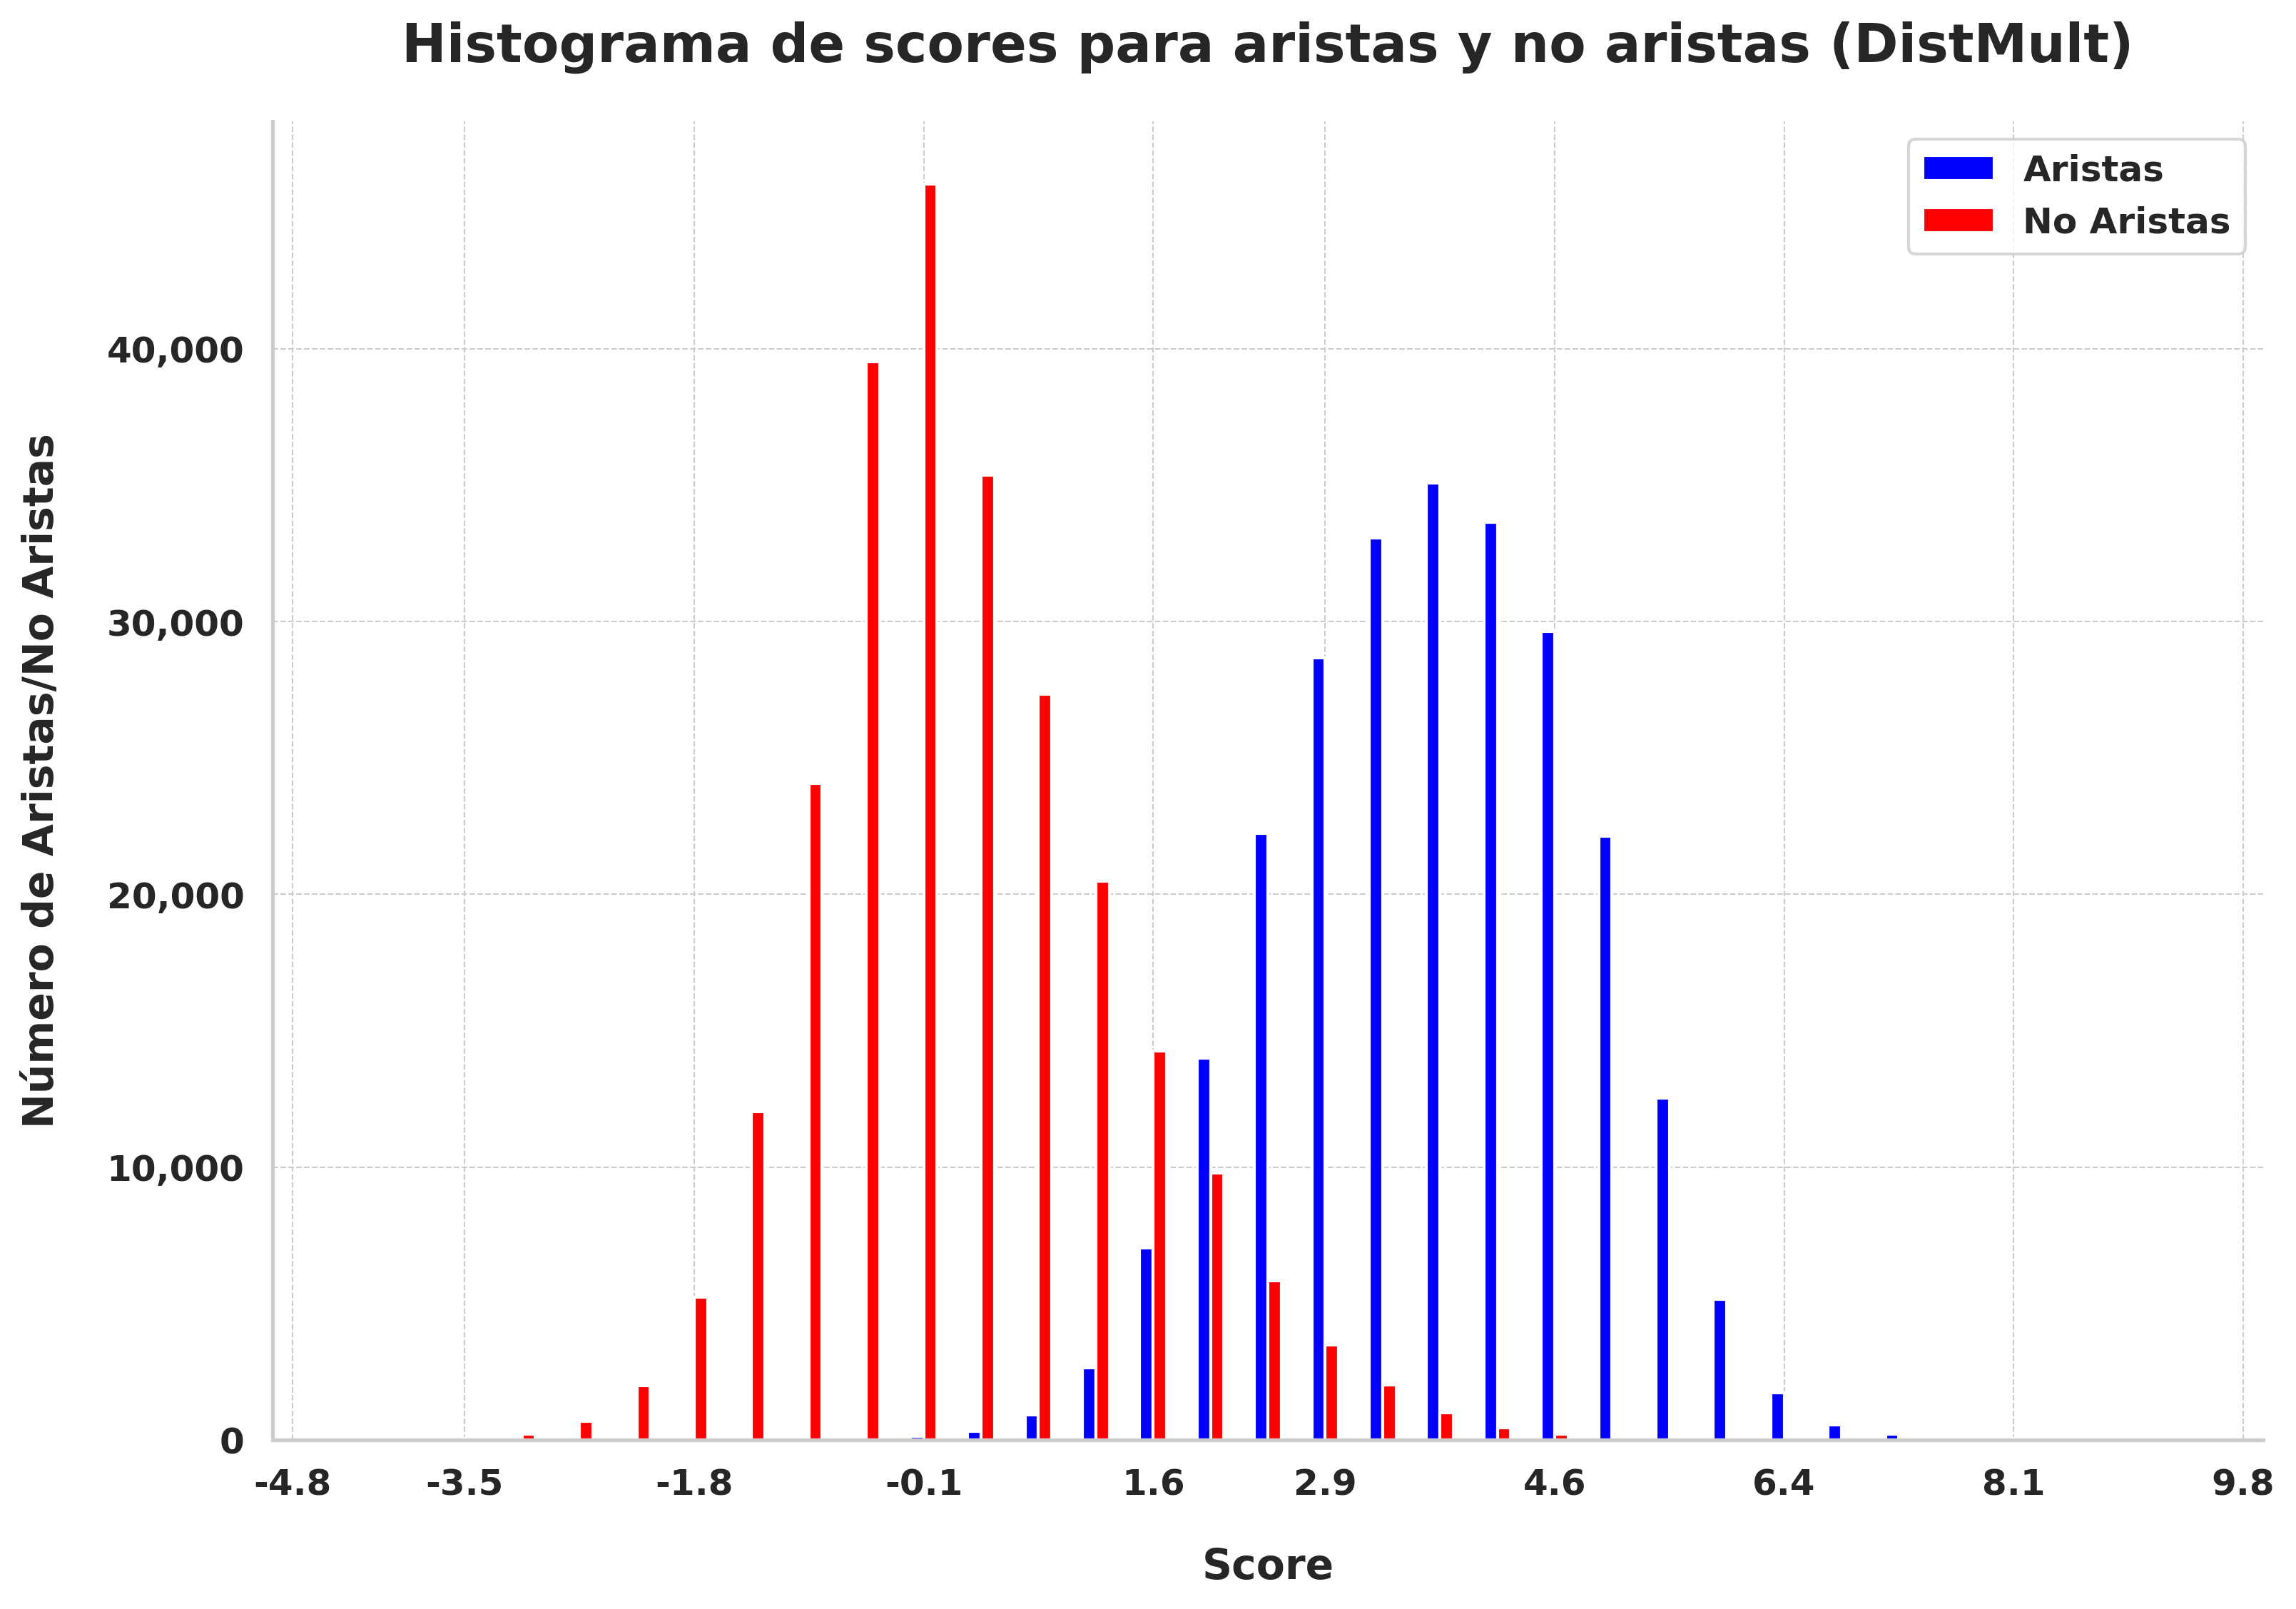

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np

# Configuración del estilo de la gráfica
sns.set(style="whitegrid")

# Preparamos los datos para la gráfica
bin_centers = np.array(list(histogram_data['actual_edges'].keys()))
edges_count = np.array(list(histogram_data['actual_edges'].values()))
non_edges_count = np.array(list(histogram_data['random_edges'].values()))

# Creamos la figura y la gráfica de barras apiladas
plt.figure(figsize=(12, 8), dpi=300)   # Configuración de alta resolución con dpi=300

# Desplazar las barras de "No Aristas" para que queden al lado de las de "Aristas"
bar_width = 0.1  # Ancho de las barras
bin_centers_shifted = bin_centers + bar_width  # Desplazamiento de las barras de "No Aristas"

# Barras para las aristas reales (azul) y no aristas (rojo)
plt.bar(bin_centers, edges_count, width=bar_width, color='blue', label='Aristas')
plt.bar(bin_centers_shifted, non_edges_count, width=bar_width, color='red', label='No Aristas')

# Añadir títulos y etiquetas (fuente grande y negrita)
plt.title('Histograma de scores para aristas y no aristas (DistMult)', fontsize=18, weight='bold', pad=20)
plt.xlabel('Score', fontsize=14, weight='bold', labelpad=15)
plt.ylabel('Número de Aristas/No Aristas', fontsize=14, weight='bold', labelpad=15)

# Configurar los límites del eje x
plt.xlim(bin_centers[0] - bar_width, bin_centers[-1] + 2 * bar_width)

# Ajustamos el tamaño y número de las etiquetas
num_ticks = 10
tick_indices = np.linspace(0, len(bin_centers) - 1, num_ticks, dtype=int)
xticks_labels = [f'{bin_centers[i]:.1f}' for i in tick_indices]
plt.xticks(bin_centers[tick_indices] + bar_width / 2, labels=xticks_labels, fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

# Añadimos la leyenda y ajustar su posición
legend = plt.legend(fontsize=12, loc='upper right')
for text in legend.get_texts():
    text.set_weight('bold')

# Formateamos el eje Y para mejor visualización
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Añadir la cuadrícula al fondo del gráfico
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Eliminamos bordes superiores y derechos para un diseño más limpio
sns.despine()

# Guardamos la figura en alta resolución
plt.savefig('distmult_histogram.png', dpi=300, bbox_inches='tight')

# Mostramos la gráfica
plt.show()


In [65]:
import numpy as np
import random
import torch

min_score_value = -2.5
max_score_value = 5

bin_edges = np.linspace(min_score_value, max_score_value, 36)
bin_centers = np.round((bin_edges[:-1] + bin_edges[1:]) / 2, 4)

histogram_data = {
    'actual_edges': {center: 0 for center in bin_centers},
    'random_edges': {center: 0 for center in bin_centers},
}

def find_bin(score, bin_edges):
    for i in range(len(bin_edges) - 1):
        if bin_edges[i] <= score < bin_edges[i + 1]:
            return bin_centers[i]
    return bin_centers[-1]

model_load_path = 'complex_model.pth'
loaded_model = model_map['complex'](
    num_nodes=data.num_nodes,
    num_relations=data.edge_type.max().item() + 1,
    hidden_channels=50,
    **model_arg_map.get('complex', {}),
).to(device)

loaded_model.load_state_dict(torch.load(model_load_path))
loaded_model.eval()

edges_sample = random.sample(list(G.edges()), 250000)

c = 0
for (head, tail) in edges_sample:
    head_tensor = torch.tensor([head]).to(device)
    relation_tensor = torch.tensor([0]).to(device)
    tail_tensor = torch.tensor([tail]).to(device)
    score = loaded_model(head_tensor, relation_tensor, tail_tensor).item()

    bin_center = find_bin(score, bin_edges)
    histogram_data['actual_edges'][bin_center] += 1

    c += 1
    if c%1000 == 0: print('actual_edges', c)

non_edges_sample = set()

c = 0
while len(non_edges_sample) < 250000:
    head = random.randint(0, data.num_nodes - 1)
    tail = random.randint(0, data.num_nodes - 1)
    if (head, tail) not in G.edges() and (tail, head) not in G.edges():
        non_edges_sample.add((head, tail))
        head_tensor = torch.tensor([head]).to(device)
        relation_tensor = torch.tensor([0]).to(device)
        tail_tensor = torch.tensor([tail]).to(device)
        score = loaded_model(head_tensor, relation_tensor, tail_tensor).item()

        bin_center = find_bin(score, bin_edges)
        histogram_data['random_edges'][bin_center] += 1

        c += 1
        if c%1000 == 0: print('random_edges', c)


actual_edges 1000
actual_edges 2000
actual_edges 3000
actual_edges 4000
actual_edges 5000
actual_edges 6000
actual_edges 7000
actual_edges 8000
actual_edges 9000
actual_edges 10000
actual_edges 11000
actual_edges 12000
actual_edges 13000
actual_edges 14000
actual_edges 15000
actual_edges 16000
actual_edges 17000
actual_edges 18000
actual_edges 19000
actual_edges 20000
actual_edges 21000
actual_edges 22000
actual_edges 23000
actual_edges 24000
actual_edges 25000
actual_edges 26000
actual_edges 27000
actual_edges 28000
actual_edges 29000
actual_edges 30000
actual_edges 31000
actual_edges 32000
actual_edges 33000
actual_edges 34000
actual_edges 35000
actual_edges 36000
actual_edges 37000
actual_edges 38000
actual_edges 39000
actual_edges 40000
actual_edges 41000
actual_edges 42000
actual_edges 43000
actual_edges 44000
actual_edges 45000
actual_edges 46000
actual_edges 47000
actual_edges 48000
actual_edges 49000
actual_edges 50000
actual_edges 51000
actual_edges 52000
actual_edges 53000
ac

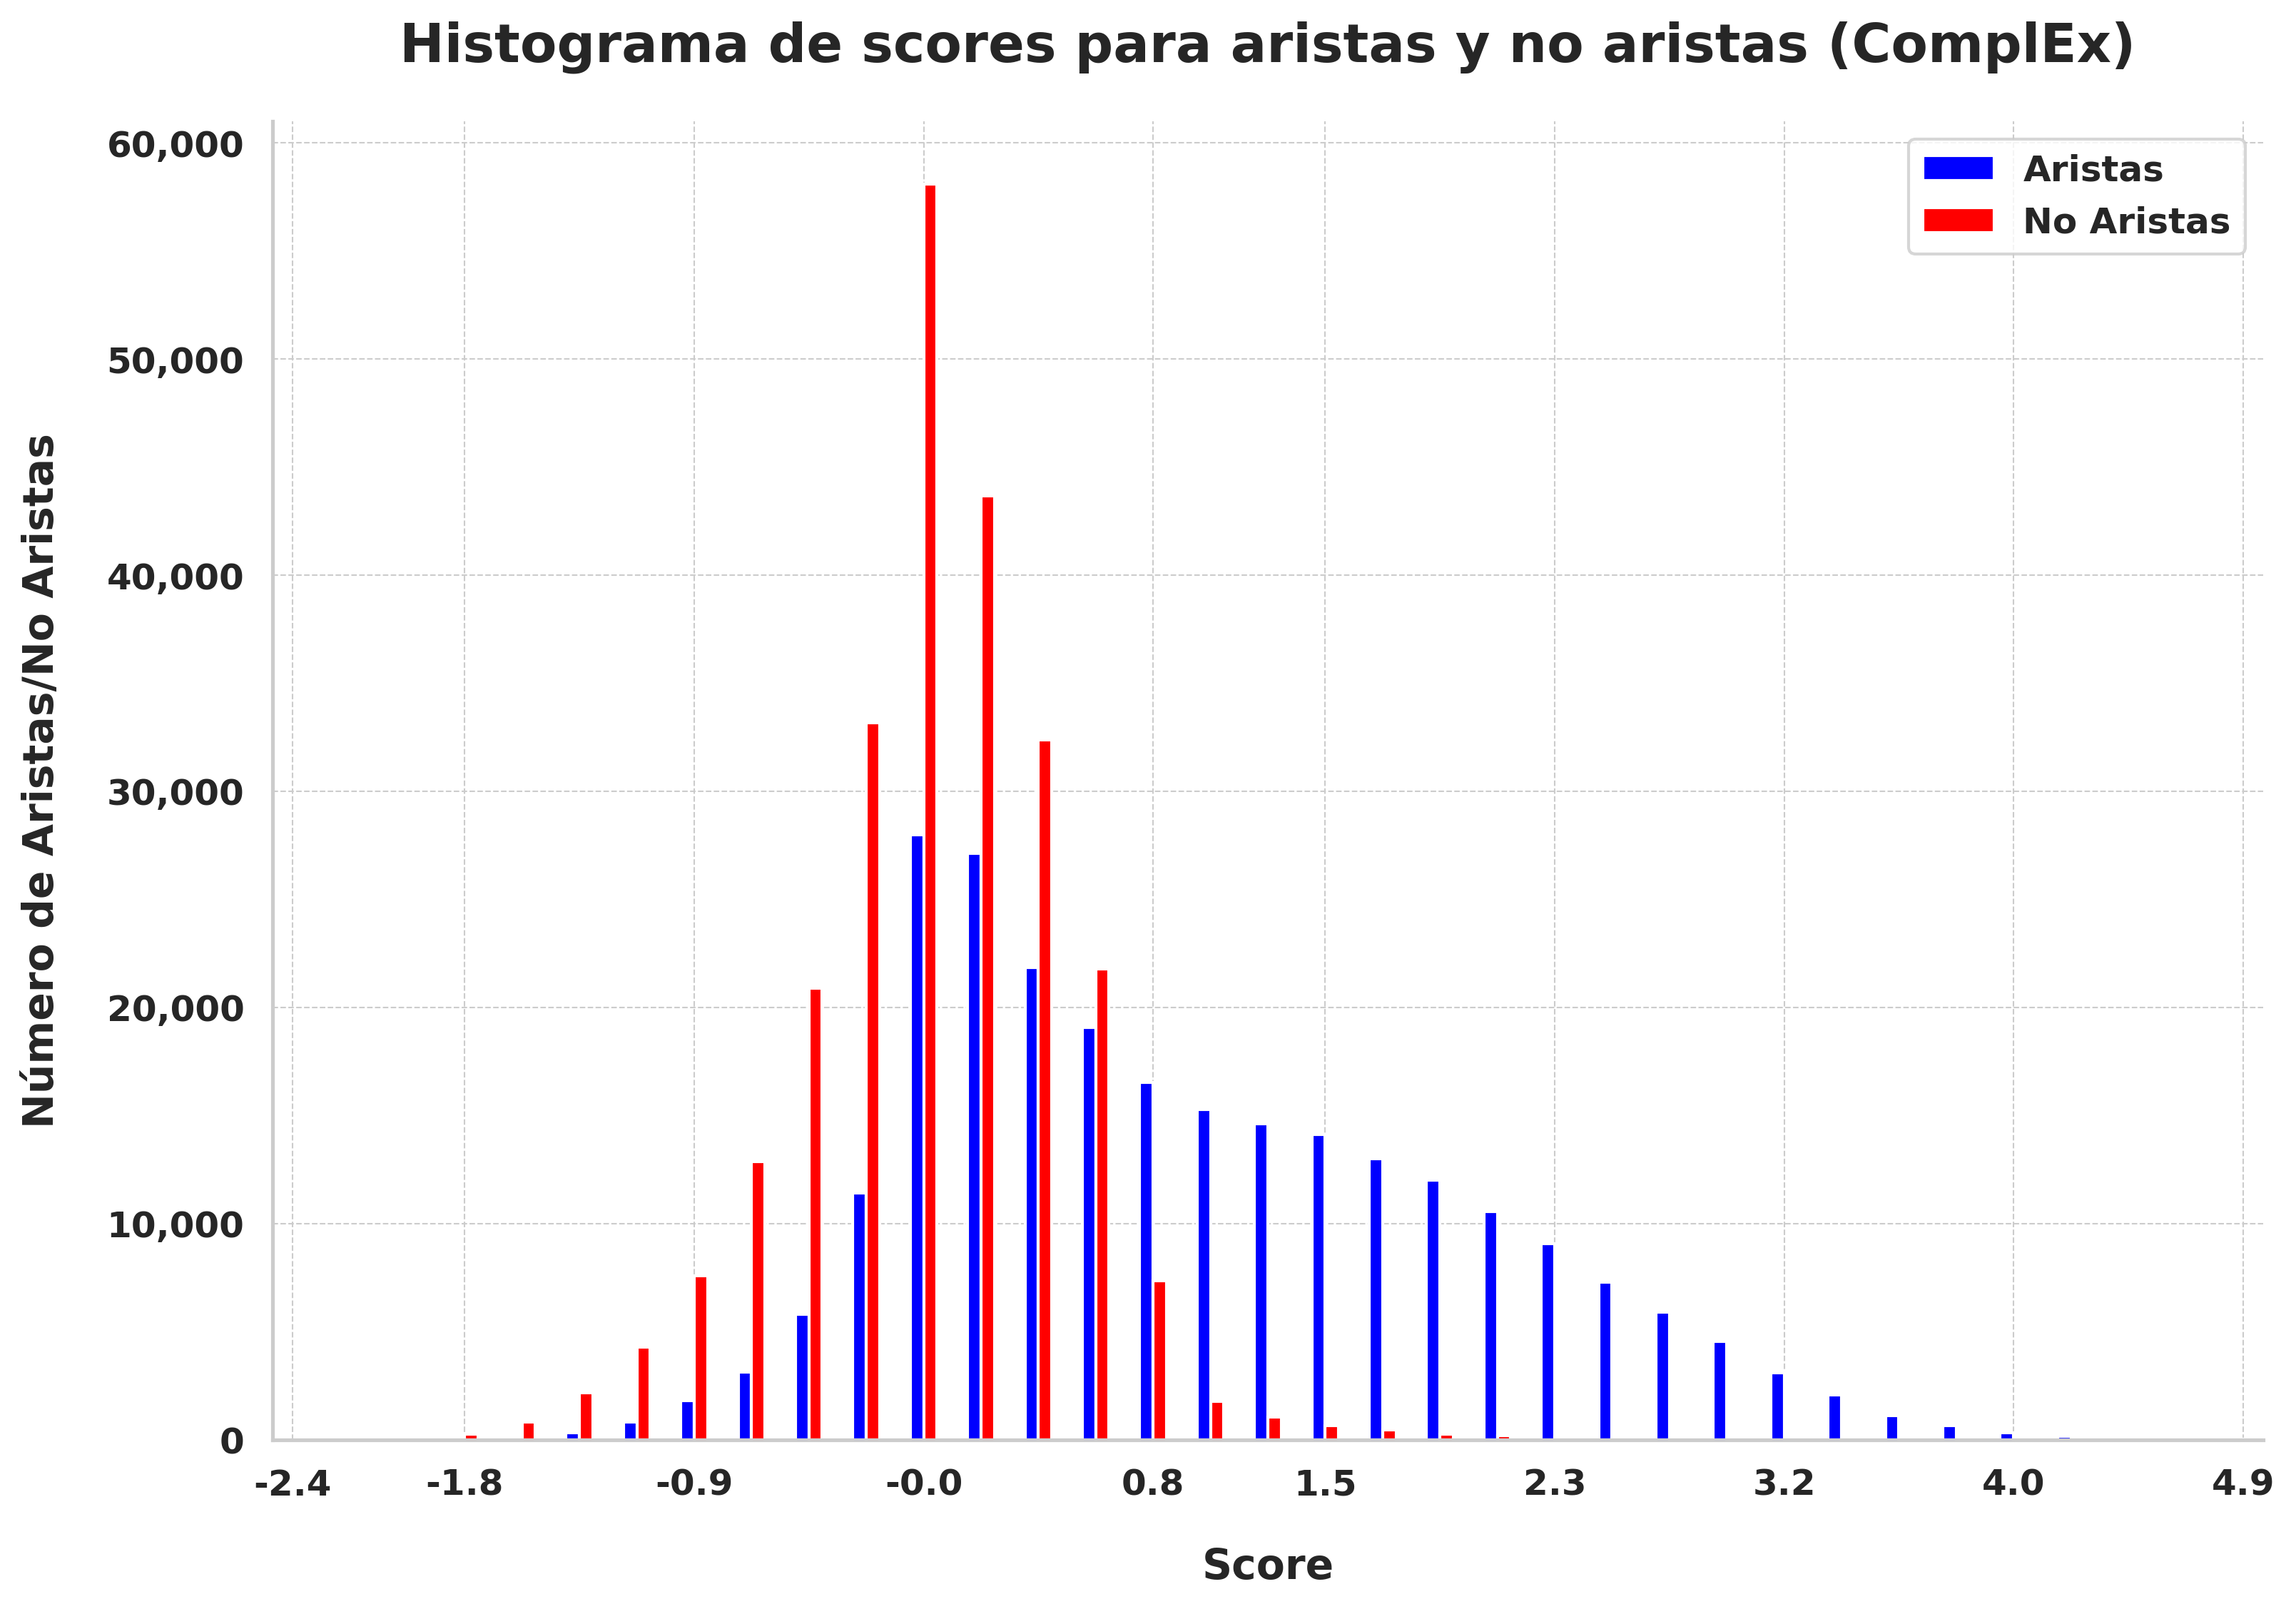

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np

# Configuración del estilo de la gráfica
sns.set(style="whitegrid")

# Preparamos los datos para la gráfica
bin_centers = np.array(list(histogram_data['actual_edges'].keys()))
edges_count = np.array(list(histogram_data['actual_edges'].values()))
non_edges_count = np.array(list(histogram_data['random_edges'].values()))

# Creamos la figura y la gráfica de barras apiladas
plt.figure(figsize=(12, 8), dpi=300)  # Configuración de alta resolución con dpi=300

# Barras para las aristas reales (azul) y no aristas (rojo)
bar_width = 0.05
bin_centers_shifted = bin_centers + bar_width
plt.bar(bin_centers, edges_count, width=bar_width, color='blue', label='Aristas')
plt.bar(bin_centers_shifted, non_edges_count, width=bar_width, color='red', label='No Aristas')

# Añadir títulos y etiquetas (fuente grande y negrita)
plt.title('Histograma de scores para aristas y no aristas (ComplEx)', fontsize=18, weight='bold', pad=20)
plt.xlabel('Score', fontsize=14, weight='bold', labelpad=15)
plt.ylabel('Número de Aristas/No Aristas', fontsize=14, weight='bold', labelpad=15)

# Configurar los límites del eje x
plt.xlim(bin_centers[0] - bar_width, bin_centers[-1] + 2 * bar_width)

# Ajustamos el tamaño y número de las etiquetas
num_ticks = 10
tick_indices = np.linspace(0, len(bin_centers) - 1, num_ticks, dtype=int)
xticks_labels = [f'{bin_centers[i]:.1f}' for i in tick_indices]
plt.xticks(bin_centers[tick_indices] + bar_width / 2, labels=xticks_labels, fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

# Añadimos la leyenda y ajustar su posición
legend = plt.legend(fontsize=12, loc='upper right')

# Poner en negrita las etiquetas de la leyenda
for text in legend.get_texts():
    text.set_weight('bold')

# Formateamos el eje Y para mejor visualización
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Añadir la cuadrícula al fondo del gráfico
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Eliminamos bordes superiores y derechos para un diseño más limpio
sns.despine()

# Guardamos la figura en alta resolución
plt.savefig('complex_histogram.png', dpi=300, bbox_inches='tight')

# Mostramos la gráfica
plt.show()


In [16]:
model_load_path = 'complex_model.pth'
loaded_model = model_map['complex'](
    num_nodes=data.num_nodes,
    num_relations=data.edge_type.max().item() + 1,
    hidden_channels=50,
    **model_arg_map.get('complex', {}),
).to(device)

loaded_model.load_state_dict(torch.load(model_load_path))
loaded_model.eval()

max_score = float('-inf')
min_score = float('inf')

lst = list(G.edges())

for (head, tail) in lst:
    head_tensor = torch.tensor([head]).to(device)
    relation_tensor = torch.tensor([0]).to(device)
    tail_tensor = torch.tensor([tail]).to(device)
    score = loaded_model(head_tensor, relation_tensor, tail_tensor).item()

    max_score = max(max_score, score)
    min_score = min(min_score, score)

print(f"Maximum score: {max_score}")
print(f"Minimum score: {min_score}")


Maximum score: 5.165124416351318
Minimum score: -2.3624136447906494
